In [1]:
from qdrant_client import QdrantClient

from RAGModule.retrieve import retrieve_relevant_chunks
from RAGModule.utils import format_chunks

from typing import Sequence

from langchain_core.language_models import BaseChatModel
from langchain_core.tools import BaseTool, tool
from langchain_core.messages import (
    BaseMessage,
    FunctionMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableBranch
from langchain_groq import ChatGroq
from llm_compiler.output_parser import LLMCompilerPlanParser, Task

import re
import time
from concurrent.futures import ThreadPoolExecutor, wait
from typing import Any, Dict, Iterable, List, Union

from langchain_core.runnables import (
    chain as as_runnable,
)
from typing_extensions import TypedDict

import functools
import itertools


import torch
from transformers import AutoModel
from FlagEmbedding import BGEM3FlagModel

torch.set_grad_enabled(False)

from dotenv import load_dotenv
load_dotenv()

/home/taiquach123471/anaconda3/envs/insomnia_chatbot_v2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'llm_compiler.output_parser'

In [ ]:
with open("llm_compiler_prompt.txt") as f:
    system_prompt_v2 = f.read()

with open("joiner_prompt.txt") as f:
    system_joiner_prompt = f.read()

prompt_v2 = ChatPromptTemplate([
    ("system", system_prompt_v2),
    MessagesPlaceholder(variable_name="messages"),
    ("system", "Remember, ONLY respond with the task list in the correct format! E.g.:\nidx. tool(arg_name=args)")
])

joiner_prompt = ChatPromptTemplate([
    ("system", system_joiner_prompt),
    MessagesPlaceholder(variable_name="messages")
])

In [ ]:
client = QdrantClient("http://localhost:6333")
llm = ChatGroq(model="llama-3.1-70b-versatile", temperature=0)
bge_m3 = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)
jina_v3 = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True).to('cuda')

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 26664.36it/s]
/home/taiquach123471/anaconda3/envs/insomnia_chatbot_v2/lib/python3.11/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue

In [ ]:
system_prompt = """You are an AI chatbot designed to answer questions about insomnia using context retrieved from scientific articles and previous chat history. Your goal is to provide clear, evidence-based responses and practical advice to help users. Following those instructions:

1. Use the information provided within the <context> tags regarding insomnia whenever available.
2. If no <context> is provided but the chat history provides sufficient information to address the user's query, use the chat history.
3. If a question is unclear or needs more context, ask the user for clarification.

<context>
{context}
</context>
"""

response_prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder("messages"),
])

response_llm = response_prompt | llm

In [ ]:
retrieve_relevant_chunks = functools.partial(retrieve_relevant_chunks, jina_embedding = jina_v3, bge_embedding = bge_m3, client = client)

@tool
def retrieve_and_answer(query: str) -> str:
    """retrieve_and_answer(query="the search query") - This tool retrieves relevant information from a vector store containing insomnia-related data. \nBased on the retrieved information, it generates a precise answer to the user's query. The tool is designed to handle various types of questions, from simple factual queries to more complex, multi-hop inquiries, by leveraging both dense and sparse vectors for optimal retrieval performance."""
    
    relevant_chunks = retrieve_relevant_chunks(query=query)
    relevant_chunks = format_chunks(relevant_chunks)

    response = response_llm.invoke({"messages": [HumanMessage(content = query)], "context": relevant_chunks})

    return response

In [ ]:
tools = [retrieve_and_answer]

In [ ]:
def create_planner(
    llm: BaseChatModel, tools: Sequence[BaseTool], base_prompt: ChatPromptTemplate
):
    tool_descriptions = "\n".join(
        f"{i+1}. {tool.description}\n"
        for i, tool in enumerate(
            tools
        )  # +1 to offset the 0 starting index, we want it count normally from 1.
    )
    planner_prompt = base_prompt.partial(
        replan="",
        num_tools=len(tools)
        + 1,  # Add one because we're adding the join() tool at the end.
        tool_descriptions=tool_descriptions,
    )

    replanner_prompt = base_prompt.partial(
        replan=' - You are given "Previous Plan" which is the plan that the previous agent created along with the execution results '
        "(given as Observation) of each plan and a general thought (given as Thought) about the executed results."
        'You MUST use these information to create the next plan under "Current Plan".\n'
        ' - When starting the Current Plan, you should start with "Thought" that outlines the strategy for the next plan.\n'
        " - In the Current Plan, you should NEVER repeat the actions that are already executed in the Previous Plan.\n"
        " - You must continue the task index from the end of the previous one. Do not repeat task indices.",
        num_tools=len(tools) + 1,
        tool_descriptions=tool_descriptions,
    )

    def should_replan(state: list):
        # Context is passed as a system message
        return isinstance(state[-1], SystemMessage)

    def wrap_messages(state: list):
        return {"messages": state}

    def wrap_and_get_last_index(state: list):
        next_task = 0
        for message in state[::-1]:
            if isinstance(message, FunctionMessage):
                next_task = message.additional_kwargs["idx"] + 1
                break
        state[-1].content = state[-1].content + f" - Begin counting at : {next_task}"
        return {"messages": state}

    return (
        RunnableBranch(
            (should_replan, wrap_and_get_last_index | replanner_prompt),
            wrap_messages | planner_prompt,
        )
        | llm
        | LLMCompilerPlanParser(tools=tools)
    )

planner = create_planner(llm, tools, prompt_v2)

In [ ]:
def _get_observations(messages: List[BaseMessage]) -> Dict[int, Any]:
    # Get all previous tool responses
    results = {}
    for message in messages[::-1]:
        if isinstance(message, FunctionMessage):
            results[int(message.additional_kwargs["idx"])] = message.content
    return results


class SchedulerInput(TypedDict):
    messages: List[BaseMessage]
    tasks: Iterable[Task]


def _execute_task(task, observations, config):
    tool_to_use = task["tool"]
    if isinstance(tool_to_use, str):
        return tool_to_use
    args = task["args"]
    try:
        if isinstance(args, str):
            resolved_args = _resolve_arg(args, observations)
        elif isinstance(args, dict):
            resolved_args = {
                key: _resolve_arg(val, observations) for key, val in args.items()
            }
        else:
            # This will likely fail
            resolved_args = args
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}.)"
            f" Args could not be resolved. Error: {repr(e)}"
        )
    try:
        return tool_to_use.invoke(resolved_args, config)
    except Exception as e:
        return (
            f"ERROR(Failed to call {tool_to_use.name} with args {args}."
            + f" Args resolved to {resolved_args}. Error: {repr(e)})"
        )


def _resolve_arg(arg: Union[str, Any], observations: Dict[int, Any]):
    # $1 or ${1} -> 1
    ID_PATTERN = r"\$\{?(\d+)\}?"

    def replace_match(match):
        # If the string is ${123}, match.group(0) is ${123}, and match.group(1) is 123.

        # Return the match group, in this case the index, from the string. This is the index
        # number we get back.
        idx = int(match.group(1))
        return str(observations.get(idx, match.group(0)))

    # For dependencies on other tasks
    if isinstance(arg, str):
        return re.sub(ID_PATTERN, replace_match, arg)
    elif isinstance(arg, list):
        return [_resolve_arg(a, observations) for a in arg]
    else:
        return str(arg)


@as_runnable
def schedule_task(task_inputs, config):
    task: Task = task_inputs["task"]
    observations: Dict[int, Any] = task_inputs["observations"]
    try:
        observation = _execute_task(task, observations, config)
    except Exception:
        import traceback

        observation = traceback.format_exception()  # repr(e) +
    observations[task["idx"]] = observation


def schedule_pending_task(
    task: Task, observations: Dict[int, Any], retry_after: float = 0.2
):
    while True:
        deps = task["dependencies"]
        if deps and (any([dep not in observations for dep in deps])):
            # Dependencies not yet satisfied
            time.sleep(retry_after)
            continue
        schedule_task.invoke({"task": task, "observations": observations})
        break


@as_runnable
def schedule_tasks(scheduler_input: SchedulerInput) -> List[FunctionMessage]:
    """Group the tasks into a DAG schedule."""
    # For streaming, we are making a few simplifying assumption:
    # 1. The LLM does not create cyclic dependencies
    # 2. That the LLM will not generate tasks with future deps
    # If this ceases to be a good assumption, you can either
    # adjust to do a proper topological sort (not-stream)
    # or use a more complicated data structure
    tasks = scheduler_input["tasks"]
    args_for_tasks = {}
    messages = scheduler_input["messages"]
    # If we are re-planning, we may have calls that depend on previous
    # plans. Start with those.
    observations = _get_observations(messages)
    task_names = {}
    originals = set(observations)
    # ^^ We assume each task inserts a different key above to
    # avoid race conditions...
    futures = []
    retry_after = 0.25  # Retry every quarter second
    with ThreadPoolExecutor() as executor:
        for task in tasks:
            deps = task["dependencies"]
            task_names[task["idx"]] = (
                task["tool"] if isinstance(task["tool"], str) else task["tool"].name
            )
            args_for_tasks[task["idx"]] = task["args"]
            if (
                # Depends on other tasks
                deps and (any([dep not in observations for dep in deps]))
            ):
                futures.append(
                    executor.submit(
                        schedule_pending_task, task, observations, retry_after
                    )
                )
            else:
                # No deps or all deps satisfied
                # can schedule now
                schedule_task.invoke(dict(task=task, observations=observations))
                # futures.append(executor.submit(schedule_task.invoke dict(task=task, observations=observations)))

        # All tasks have been submitted or enqueued
        # Wait for them to complete
        wait(futures)
    # Convert observations to new tool messages to add to the state
    new_observations = {
        k: (task_names[k], args_for_tasks[k], observations[k])
        for k in sorted(observations.keys() - originals)
    }
    tool_messages = [
        FunctionMessage(
            name=name,
            content=str(obs),
            additional_kwargs={"idx": k, "args": task_args},
            tool_call_id=k,
        )
        for k, (name, task_args, obs) in new_observations.items()
    ]
    return tool_messages

In [ ]:
@as_runnable
def plan_and_schedule(state):
    messages = state["messages"]
    tasks = planner.stream(messages)
    # Begin executing the planner immediately
    try:
        tasks = itertools.chain([next(tasks)], tasks)
    except StopIteration:
        # Handle the case where tasks is empty.
        tasks = iter([])
    scheduled_tasks = schedule_tasks.invoke(
        {
            "messages": messages,
            "tasks": tasks,
        }
    )
    return {"messages": scheduled_tasks}

In [ ]:
from langchain_core.messages import AIMessage

from pydantic import BaseModel, Field


class FinalResponse(BaseModel):
    """The final response to a user query."""
    response: str = Field(
        description=("A detailed, comprehensive and user-centric response to the query, fully derived from the chain of thought reasoning and the provided context. "
                     "Ensure the response is clear, complete, and addresses all aspects of the query effectively."))


class Replan(BaseModel):
    """Suggestions to improve the response generation."""
    feedback: str = Field(
        description="Analysis of the previous attempts and recommendations on what needs to be fixed."
    )


class JoinOutputs(BaseModel):
    """Decide whether to replan or whether you can return the final response."""
    thought: str = Field(
        description="The chain of thought reasoning for the selected action, including logical steps and connections between the query and provided context."
    )
    action: Union[FinalResponse, Replan] = Field(description= "The action to take based on the chain of thought reasoning. It should be either FinalResponse or Replan.")
    

#class JoinOutputs_v2(BaseModel):
#    """Decide whether to replan or you can return the final response."""
#    thought: str = Field(
#        description="The chain of thought reasoning for the selected action, including logical steps and connections between the query and provided context."
#    )
#    should_replan: bool = Field(description="Whether to replan or not")
#    response: str = Field(
#        description=("If should_replan is True, response should be analysis of the previous attempts and recommendations on what needs to be fixed.\n"
#                     "If should_replan is False, response should be comprehensive and directly informed by the thought process and provided information."))

In [ ]:
def _parse_joiner_output(decision: JoinOutputs) -> List[BaseMessage]:
    response = [AIMessage(content=f"Thought: {decision.thought}")]
    if isinstance(decision.action, Replan):
        return {
            "messages": response
            + [
                SystemMessage(
                    content=f"Context from last attempt: {decision.action.feedback}"
                )
            ]
        }
    else:
        return {"messages": response + [AIMessage(content=decision.action.response)]}


def select_recent_messages(state) -> dict:
    messages = state["messages"]
    selected = []
    for msg in messages[::-1]:
        selected.append(msg)
        if isinstance(msg, HumanMessage):
            break
    return {"messages": selected[::-1]}

In [ ]:
query = "Tell me common causes of insomnia in teenagers. Does caffeine one of them?"

for task in planner.stream([HumanMessage(content = query)]):
    print(task["tool"], task["args"])
    print("---")

print('='*30)

tool_messages = plan_and_schedule.invoke({"messages": [HumanMessage(content=query)]})['messages']
tool_messages

name='retrieve_and_answer' description='retrieve_and_answer(query="the search query") - This tool retrieves relevant information from a vector store containing insomnia-related data. \nBased on the retrieved information, it generates a precise answer to the user\'s query. The tool is designed to handle various types of questions, from simple factual queries to more complex, multi-hop inquiries, by leveraging both dense and sparse vectors for optimal retrieval performance.' args_schema=<class 'langchain_core.utils.pydantic.retrieve_and_answer'> func=<function retrieve_and_answer at 0x7c1b2b423ce0> {'query': 'common causes of insomnia in teenagers'}
---
name='retrieve_and_answer' description='retrieve_and_answer(query="the search query") - This tool retrieves relevant information from a vector store containing insomnia-related data. \nBased on the retrieved information, it generates a precise answer to the user\'s query. The tool is designed to handle various types of questions, from sim

Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


[FunctionMessage(content='content="Based on the provided context, several common causes of insomnia in teenagers can be identified:\\n\\n1. **Caffeine consumption**: Consuming caffeinated beverages, especially energy drinks, can lead to insomnia in teenagers. Caffeine can disrupt sleep patterns and make it difficult to fall asleep (Source: CHUNK 2).\\n2. **Stress and anxiety**: Stress and anxiety can contribute to insomnia in teenagers. This can be due to various factors such as academic pressure, social relationships, or emotional distress (Source: CHUNK 2 and CHUNK 4).\\n3. **Depression**: Depression is a common comorbidity with insomnia in teenagers. Insomnia symptoms can trigger depressive symptoms, and vice versa (Source: CHUNK 1 and CHUNK 4).\\n4. **Non-suicidal self-injury (NSSI)**: There is a bidirectional link between insomnia symptoms and NSSI in teenagers. Insomnia can contribute to the development of NSSI, and NSSI can also exacerbate insomnia symptoms (Source: CHUNK 1 and 

In [ ]:
runnable = joiner_prompt | llm.with_structured_output(JoinOutputs)
joiner = select_recent_messages | runnable | _parse_joiner_output

In [ ]:
res = joiner.invoke({"messages": [HumanMessage(content = query)] + tool_messages})

In [ ]:
res

{'messages': [AIMessage(content='Thought: Based on the provided context, several common causes of insomnia in teenagers can be identified, including caffeine consumption, stress and anxiety, depression, non-suicidal self-injury (NSSI), hyperarousal, emotional regulation issues, and lifestyle factors. Caffeine consumption is one of the causes of insomnia in teenagers.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Caffeine consumption is one of the causes of insomnia in teenagers. Other causes include stress and anxiety, depression, non-suicidal self-injury (NSSI), hyperarousal, emotional regulation issues, and lifestyle factors.', additional_kwargs={}, response_metadata={})]}

In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from langgraph.checkpoint.memory import MemorySaver


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# 1.  Define vertices
# We defined plan_and_schedule above already
# Assign each node to a state variable to update
graph_builder.add_node("plan_and_schedule", plan_and_schedule)
graph_builder.add_node("join", joiner)


## Define edges
graph_builder.add_edge("plan_and_schedule", "join")

### This condition determines looping logic


def should_continue(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage):
        return END
    return "plan_and_schedule"


graph_builder.add_conditional_edges(
    "join",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
graph_builder.add_edge(START, "plan_and_schedule")
chain = graph_builder.compile(checkpointer=MemorySaver(), interrupt_before=["join"])

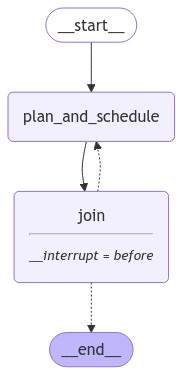

In [ ]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
config = {"configurable": {"thread_id": "0"}}

In [ ]:
for event in chain.stream({"messages": [HumanMessage(content=query)]}, config=config):
    print(event)

Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)
Failed to use model_dump to serialize <class 'langchain_core.tools.structured.StructuredTool'> to JSON: PydanticSerializationError(Unable to serialize unknown type: <class 'pydantic._internal._model_construction.ModelMetaclass'>)


{'plan_and_schedule': {'messages': [FunctionMessage(content='content="Based on the provided context, some common causes of insomnia in teenagers include:\\n\\n1. **Caffeine consumption**: Excessive caffeine consumption, especially in the form of energy drinks (EDs), has been linked to insomnia in teenagers. Caffeine can disrupt sleep patterns and make it difficult to fall asleep.\\n2. **Electronic device use**: Although not explicitly mentioned in the context, it\'s a well-known fact that exposure to screens and electronic devices before bedtime can interfere with sleep.\\n3. **Stress and anxiety**: Stress and anxiety can lead to insomnia in teenagers. This is often related to academic pressures, social relationships, and other emotional challenges.\\n4. **Depression**: Depression is a common comorbidity with insomnia in teenagers. The context suggests that depressive symptoms can be both a cause and a consequence of insomnia.\\n5. **Lifestyle factors**: Irregular sleep schedules, lack

In [ ]:
chain.get_state(config).values

{'messages': [HumanMessage(content='Tell me common causes of insomnia in teenagers. Does caffeine one of them?', additional_kwargs={}, response_metadata={}, id='73401211-70c3-4d31-a022-5da4e18bed17'),
  FunctionMessage(content='content="Based on the provided context, some common causes of insomnia in teenagers include:\\n\\n1. **Caffeine consumption**: Excessive caffeine consumption, especially in the form of energy drinks (EDs), has been linked to insomnia in teenagers. Caffeine can disrupt sleep patterns and make it difficult to fall asleep.\\n2. **Electronic device use**: Although not explicitly mentioned in the context, it\'s a well-known fact that exposure to screens and electronic devices before bedtime can interfere with sleep.\\n3. **Stress and anxiety**: Stress and anxiety can lead to insomnia in teenagers. This is often related to academic pressures, social relationships, and other emotional challenges.\\n4. **Depression**: Depression is a common comorbidity with insomnia in 

In [ ]:
for event in chain.stream(None, config=config):
    print(event)

{'join': {'messages': [AIMessage(content='Thought: Based on the provided context, caffeine consumption has been linked to insomnia in teenagers. Studies have shown that high caffeine intake can contribute to insufficient sleep among adolescents, including shorter duration, increased wake after sleep onset, and more difficulty falling or staying asleep.', additional_kwargs={}, response_metadata={}, id='b2564d39-9e9a-46ad-9534-1eef601b13b6'), AIMessage(content='Yes, caffeine is one of the common causes of insomnia in teenagers.', additional_kwargs={}, response_metadata={}, id='4ed42e7e-8ed8-48bb-baf3-1b8943108994')]}}


In [ ]:
chain.get_state(config).values

{'messages': [HumanMessage(content='Tell me common causes of insomnia in teenagers. Does caffeine one of them?', additional_kwargs={}, response_metadata={}, id='73401211-70c3-4d31-a022-5da4e18bed17'),
  FunctionMessage(content='content="Based on the provided context, some common causes of insomnia in teenagers include:\\n\\n1. **Caffeine consumption**: Excessive caffeine consumption, especially in the form of energy drinks (EDs), has been linked to insomnia in teenagers. Caffeine can disrupt sleep patterns and make it difficult to fall asleep.\\n2. **Electronic device use**: Although not explicitly mentioned in the context, it\'s a well-known fact that exposure to screens and electronic devices before bedtime can interfere with sleep.\\n3. **Stress and anxiety**: Stress and anxiety can lead to insomnia in teenagers. This is often related to academic pressures, social relationships, and other emotional challenges.\\n4. **Depression**: Depression is a common comorbidity with insomnia in 

In [ ]:
res

{'messages': [AIMessage(content='Thought: Based on the provided context, several common causes of insomnia in teenagers can be identified, including caffeine consumption, stress and anxiety, depression, non-suicidal self-injury (NSSI), hyperarousal, emotional regulation issues, and lifestyle factors. Caffeine consumption is one of the causes of insomnia in teenagers.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Caffeine consumption is one of the causes of insomnia in teenagers. Other causes include stress and anxiety, depression, non-suicidal self-injury (NSSI), hyperarousal, emotional regulation issues, and lifestyle factors.', additional_kwargs={}, response_metadata={})]}